# **Wikipedia Text Categorization**
*A machine learning project by Cielo Loy for CSE 151A at UCSD*

## The Data
Here is a link to the dataset:
https://huggingface.co/datasets/wikimedia/structured-wikipedia

Structured Wikipedia is a dataset containing English and French Wikipedia articles and their attributes, though this project will pare that down to a smaller subset within the set of English-only articles. 

For the environment, we will use the following: 
- Python v3.13.5
- datasets v3.0 (for hugging-face)
- pandas v2.3.1
- numpy v2.3.2
- matplotlib v3.10.5
- scikit-learn v1.7.1
- seaborn v0.13.2


## Data Plots

*Plot your data with various types of charts like bar charts, pie charts, scatter plots etc. and clearly explain the plots.*

In [1]:
import seaborn as sns
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

*Note: the following was partially generated with ChatGPT as I had trouble importing the hugging-face dataset into pandas on my own.*

In [2]:
from datasets import load_dataset

ds = load_dataset("wikimedia/structured-wikipedia", "20240916.en", split="train", streaming=True)

# Grab a small sample of rows, 1000 articles
sample = []
for i, row in enumerate(ds):
    if i >= 1000:
        break
    sample.append(row)

df = pd.DataFrame(sample)
df.to_csv("sample.csv", index=False)

c:\Users\loy20\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here are two plots showing the length of article `name`s and `abstract`s within the small 1000-article sample. I was having a lot of trouble trying to use pandas with the JSON structs within the original dataset, so I will include plots on this data (especially `infobox`) in the future once I figure it out.

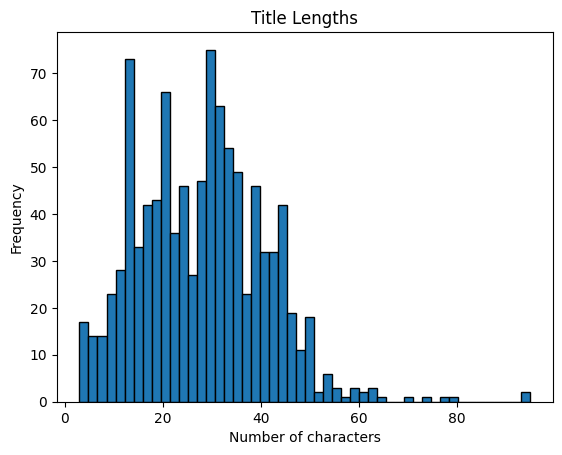

In [3]:
# Title lengths
df["name_length"] = df["name"].astype(str).apply(len)
plt.hist(df["name_length"], bins=50, edgecolor="black")
plt.title("Title Lengths")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.show()


The lengths of article titles are frequently between 5 and 50 characters long. Their range is from 0 to 100.

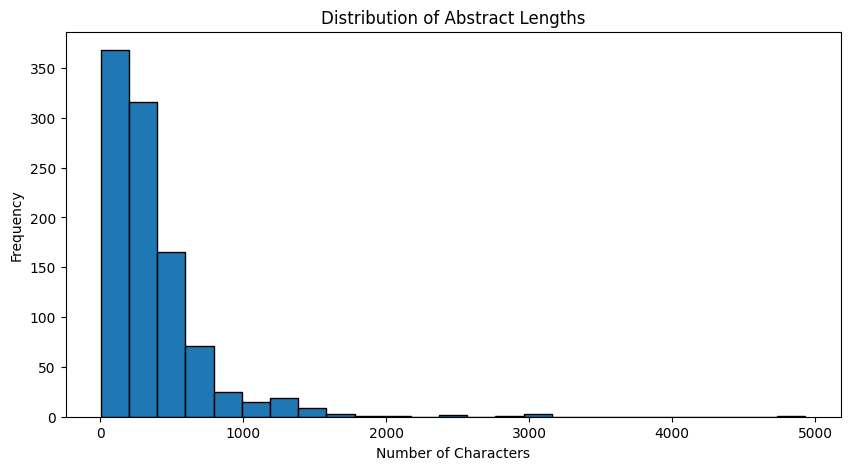

In [4]:
# Abstract lengths
df["abstract_length"] = df["abstract"].astype(str).apply(len)
plt.figure(figsize=(10,5))
plt.hist(df["abstract_length"], bins=25, edgecolor="black")
plt.title("Distribution of Abstract Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

The lengths of abstracts are frequently between 0 and 1000 characters, dropping off after that. The longest samples seem to be around 5000 characters in length.

## Preprocessing

*Finish major preprocessing, this includes scaling and/or transforming your data, imputing your data, encoding your data, feature expansion, Feature expansion (example is taking features and generating new features by transforming via polynomial, log multiplication of features).*

In [ ]:
import json
import zipfile
import os

# ----- Config -----
zip_filename = "enwiki_namespace_0.zip"  # your local ZIP in the same folder
categories = {
    "arts_entertainment": {
        "infobox": ["musical artist", "actor", "film", "album", "television", "writer", "artist"],
        "keywords": ["music", "film", "television", "movie", "novel", "painter", "theater", "art", "concert"]
    },
    "geography": {
        "infobox": ["country", "settlement", "mountain", "river", "lake", "city", "state"],
        "keywords": ["continent", "country", "city", "mountain", "river", "valley", "island", "ocean", "desert"]
    },
    "stem": {
        "infobox": ["scientist", "chemical", "species", "protein", "enzyme", "mathematician", "astronomical object"],
        "keywords": ["biology", "chemistry", "physics", "mathematics", "engineering", "computer", "astronomy", "neuroscience"]
    }
}
max_per_category = 150_000
output_files = {cat: f"{cat}_150k.jsonl" for cat in categories}
debug_file_path = "debug_log.jsonl"
resume_state_path = "resume_state.json"

# ----- Resume state -----
if os.path.exists(resume_state_path):
    with open(resume_state_path, "r", encoding="utf-8") as f:
        resume_state = json.load(f)
    collected_counts = resume_state["collected_counts"]
    processed_lines = resume_state["processed_lines"]
else:
    collected_counts = {cat: 0 for cat in categories}
    processed_lines = 0

# ----- File handles -----
files = {cat: open(output_files[cat], "a", encoding="utf-8") for cat in categories}
debug_file = open(debug_file_path, "a", encoding="utf-8")

# ----- Stream ZIP -----
with zipfile.ZipFile(zip_filename) as z:
    for filename in z.namelist():
        if not filename.endswith(".jsonl"):
            continue
        print(f"Processing {filename} ...")
        with z.open(filename) as f:
            for line_idx, line in enumerate(f):
                # Skip already processed lines
                if line_idx < processed_lines:
                    continue
                processed_lines += 1

                try:
                    article = json.loads(line)

                    if not isinstance(article, dict) or "name" not in article:
                        continue

                    # extract infobox name
                    infobox_name = ""
                    infobox = article.get("infoboxes")
                    if infobox and isinstance(infobox, list):
                        for box in infobox:
                            if isinstance(box, dict) and box.get("name"):
                                infobox_name = str(box["name"]).lower()
                                break

                    # check each category
                    for cat, rules in categories.items():
                        if collected_counts[cat] >= max_per_category:
                            continue

                        matched = False

                        # infobox match
                        if infobox_name:
                            for inf in rules["infobox"]:
                                if inf in infobox_name:
                                    matched = True
                                    break

                        # fallback keyword match
                        if not matched:
                            name_lower = article.get("name", "").lower()
                            for kw in rules["keywords"]:
                                if kw in name_lower:
                                    matched = True
                                    break

                        if matched:
                            files[cat].write(json.dumps(article, ensure_ascii=False) + "\n")
                            collected_counts[cat] += 1
                            print(cat, collected_counts[cat])

                    # stop once all are full
                    if all(count >= max_per_category for count in collected_counts.values()):
                        break

                except Exception as e:
                    debug_file.write(json.dumps({"error": str(e), "line_idx": line_idx, "line": line.decode(errors="ignore")}, ensure_ascii=False) + "\n")
                    continue

                # save resume state every 1000 lines
                if processed_lines % 1000 == 0:
                    with open(resume_state_path, "w", encoding="utf-8") as rs:
                        json.dump({
                            "collected_counts": collected_counts,
                            "processed_lines": processed_lines
                        }, rs)

# ----- Close files -----
for f in files.values():
    f.close()
debug_file.close()
with open(resume_state_path, "w", encoding="utf-8") as rs:
    json.dump({
        "collected_counts": collected_counts,
        "processed_lines": processed_lines
    }, rs)

print("✅ Done! Saved arts_entertainment_150k.jsonl, geography_150k.jsonl, and stem_150k.jsonl")


stem 1
arts_entertainment 1
geography 1
arts_entertainment 2
arts_entertainment 3
arts_entertainment 4
geography 2
arts_entertainment 5
arts_entertainment 6
arts_entertainment 7
arts_entertainment 8
arts_entertainment 9
arts_entertainment 10
arts_entertainment 11
arts_entertainment 12
stem 2
geography 3
geography 4
arts_entertainment 13
geography 5
arts_entertainment 14
arts_entertainment 15
arts_entertainment 16
arts_entertainment 17
arts_entertainment 18
stem 3
arts_entertainment 19
arts_entertainment 20
arts_entertainment 21
arts_entertainment 22
stem 4
arts_entertainment 23
arts_entertainment 24
stem 5
stem 6
arts_entertainment 25
arts_entertainment 26
arts_entertainment 27
arts_entertainment 28
arts_entertainment 29
geography 6
geography 7
arts_entertainment 30
arts_entertainment 31
arts_entertainment 32
geography 8
arts_entertainment 33
arts_entertainment 34
arts_entertainment 35
geography 9
stem 7
geography 10
geography 11
geography 12
stem 8
stem 9
geography 13
arts_entertainme

TypeError: Couldn't cast array of type
struct<type: string, value: string, links: list<item: struct<url: string, text: string, images: list<item: struct<content_url: string, width: int64, height: int64, alternative_text: string>>>>, name: string, has_parts: list<item: struct<type: string, value: string, links: list<item: struct<url: string, text: string>>>>>
to
{'type': Value('string'), 'value': Value('string'), 'links': List({'url': Value('string'), 'text': Value('string'), 'images': List({'content_url': Value('string'), 'width': Value('int64'), 'height': Value('int64'), 'alternative_text': Value('string')})}), 'has_parts': List({'type': Value('string'), 'value': Value('string'), 'links': List({'url': Value('string'), 'text': Value('string')})})}

*Train your first model and analyze your model's performance. Evaluate your model and compare training vs. test error.*